# A pronounced loss of tree crown foliation results in multi-year growth reduction


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from models import train_and_explain, optimize_hyperparameters
import shap
import numpy as np
import polars as pl

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
group_col = "tree_id"
all_species = ["spruce", "pine", "beech", "oak"]

all_results = {}

for species in all_species:
    best_params, best_value = optimize_hyperparameters(species, group_col=group_col)
    all_results[species] = train_and_explain(species, best_params, group_col=group_col)

Training model for spruce
KS Statistic: 0.019460609288104724
P-value: 3.5e-05


/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split[LightGBM] [Warning] Unknown parameter: min_gain_split

[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4

[LightGBM] [Warning] lambda_l1 is set=1.3123269060860292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3123269060860292e-07
[LightGBM] [Warning] lambda_l1 is set=1.3123269060860292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3123269060860292e-07[LightGBM] [Warning] lambda_l2 is set=0.00015048041354196693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015048041354196693
[LightGBM] [Warning] bagging_fraction is set=0.5619039372963892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5619039372963892

[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: m

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=1.3123269060860292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3123269060860292e-07
[LightGBM] [Warning] lambda_l2 is set=0.00015048041354196693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015048041354196693
[LightGBM] [Warning] bagging_fraction is set=0.5619039372963892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5619039372963892
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.6504249467152784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504249467152784
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=1.3123269060860292e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3123269060860292e-07
[LightGBM] [Warning] lambda_l2 is set=0.00015048041354196693, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015048041354196693
[LightGBM] [Warning] bagging_fraction is set=0.5619039372963892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5619039372963892
[LightGBM] [Warning] min_data_in_leaf is set=48, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=48
[LightGBM] [Warning] feature_fraction is set=0.6504249467152784, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6504249467152784
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=2.3193744484612897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3193744484612897e-06
[LightGBM] [Warning] lambda_l2 is set=1.5991289094975802e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5991289094975802e-06
[LightGBM] [Warning] bagging_fraction is set=0.8632878825956785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8632878825956785
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5592569954165069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=2.3193744484612897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3193744484612897e-06
[LightGBM] [Warning] lambda_l2 is set=1.5991289094975802e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5991289094975802e-06
[LightGBM] [Warning] bagging_fraction is set=0.8632878825956785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8632878825956785
[LightGBM] [Warning] min_data_in

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=2.3193744484612897e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3193744484612897e-06
[LightGBM] [Warning] lambda_l2 is set=1.5991289094975802e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5991289094975802e-06
[LightGBM] [Warning] bagging_fraction is set=0.8632878825956785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8632878825956785
[LightGBM] [Warning] min_data_in_leaf is set=88, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=88
[LightGBM] [Warning] feature_fraction is set=0.5592569954165069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5592569954165069
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.6242504857913124e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6242504857913124e-06
[LightGBM] [Warning] lambda_l2 is set=1.904375144252982e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.904375144252982e-08
[LightGBM] [Warning] bagging_fraction is set=0.8987467501721609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987467501721609
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4902048683776747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4902048683776747
Finished training model for beech
Performance:
 `- R2: 0.4

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=2.6242504857913124e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6242504857913124e-06
[LightGBM] [Warning] lambda_l2 is set=1.904375144252982e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.904375144252982e-08
[LightGBM] [Warning] bagging_fraction is set=0.8987467501721609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987467501721609
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] feature_fraction is set=0.4902048683776747, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4902048683776747
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. 

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=2.3995604706268593e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3995604706268593e-05
[LightGBM] [Warning] lambda_l2 is set=0.11844729240519608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11844729240519608
[LightGBM] [Warning] bagging_fraction is set=0.77263507152719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.77263507152719
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9317258064140852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317258064140852
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

## Evaluate model performance for each species

Here we compute the mean and standard deviation of the $R^2$ (coefficient of determination) for all species and folds.

In [5]:
for species, results in all_results.items():
    perf = pl.from_dicts(results.performances).select(
        pl.first().cum_count().alias("fold"), "r2", "mae"
    )

    r2_mean = perf.select("r2").mean().item()
    r2_std = perf.select("r2").std().item()

    print(f"Results for {species}")
    print("Performance:")
    print(perf)
    print(f"R2: {r2_mean:.3f} ± {r2_std:.3f}")
    print()

Results for spruce
Performance:
shape: (5, 3)
┌──────┬──────────┬──────────┐
│ fold ┆ r2       ┆ mae      │
│ ---  ┆ ---      ┆ ---      │
│ u32  ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╡
│ 1    ┆ 0.503607 ┆ 0.156087 │
│ 2    ┆ 0.513186 ┆ 0.15095  │
│ 3    ┆ 0.52189  ┆ 0.15336  │
│ 4    ┆ 0.517152 ┆ 0.154601 │
│ 5    ┆ 0.530749 ┆ 0.151014 │
└──────┴──────────┴──────────┘
R2: 0.517 ± 0.010

Results for pine
Performance:
shape: (5, 3)
┌──────┬──────────┬──────────┐
│ fold ┆ r2       ┆ mae      │
│ ---  ┆ ---      ┆ ---      │
│ u32  ┆ f64      ┆ f64      │
╞══════╪══════════╪══════════╡
│ 1    ┆ 0.496666 ┆ 0.161019 │
│ 2    ┆ 0.444985 ┆ 0.168051 │
│ 3    ┆ 0.430556 ┆ 0.16818  │
│ 4    ┆ 0.454952 ┆ 0.165833 │
│ 5    ┆ 0.466087 ┆ 0.164292 │
└──────┴──────────┴──────────┘
R2: 0.459 ± 0.025

Results for beech
Performance:
shape: (5, 3)
┌──────┬──────────┬──────────┐
│ fold ┆ r2       ┆ mae      │
│ ---  ┆ ---      ┆ ---      │
│ u32  ┆ f64      ┆ f64      │
╞══════╪══════════╪══

## Plot predictions

Here we plot predictions for a given species and different folds. We highlight different `plot_id`s to verify that the model doesn't merely the same average for any given plot.

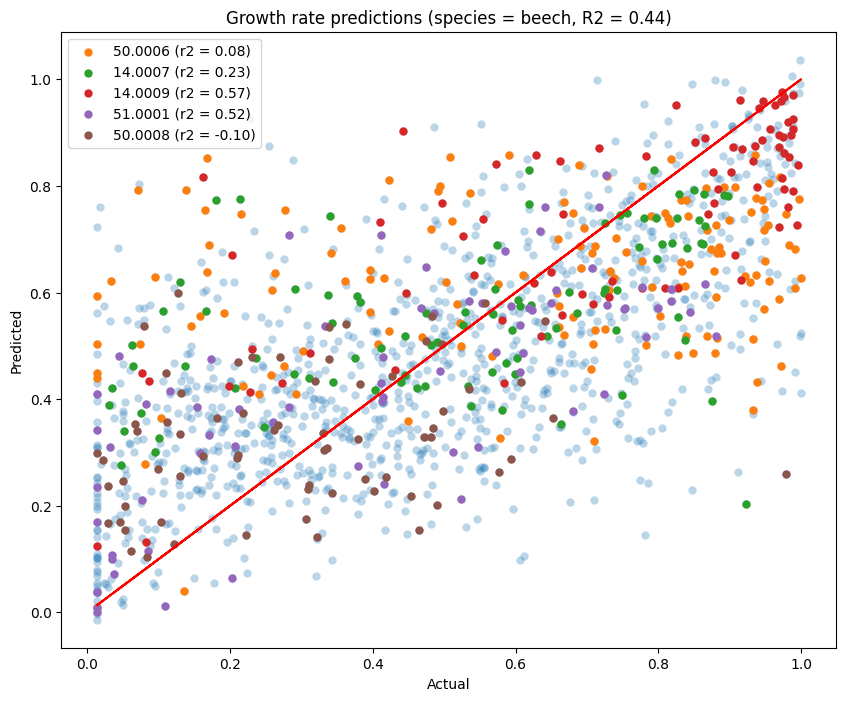

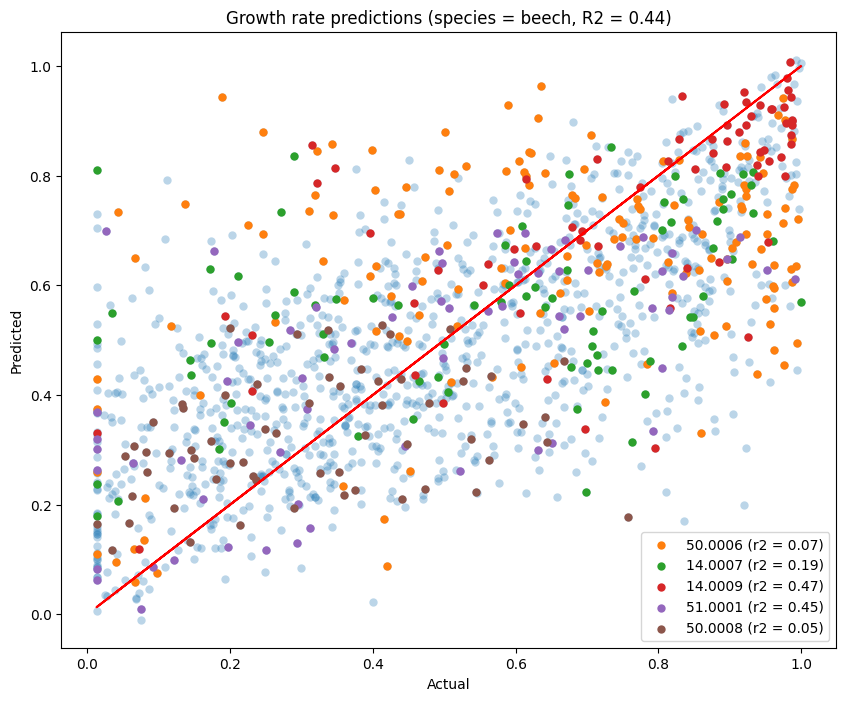

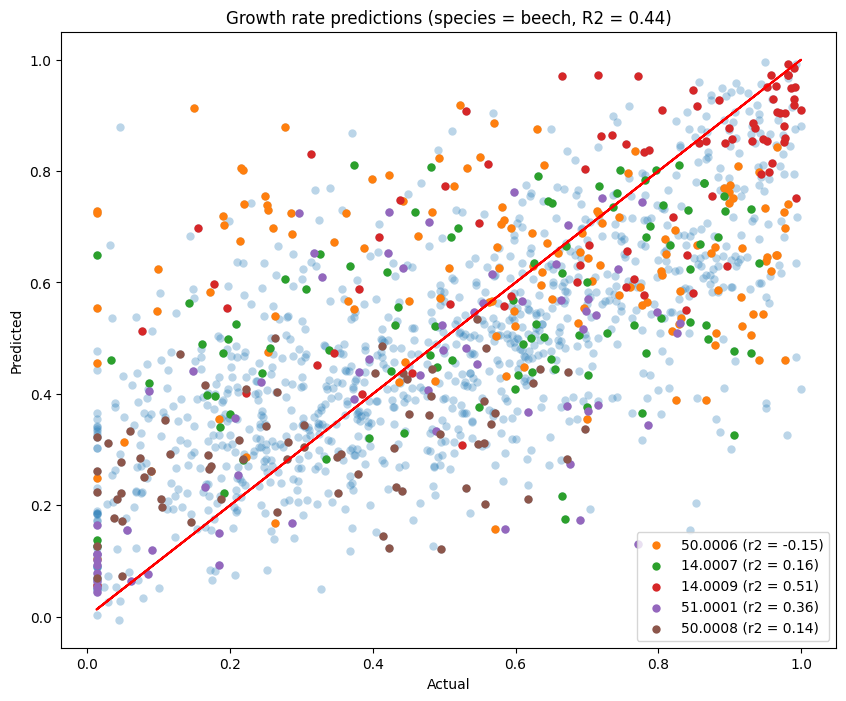

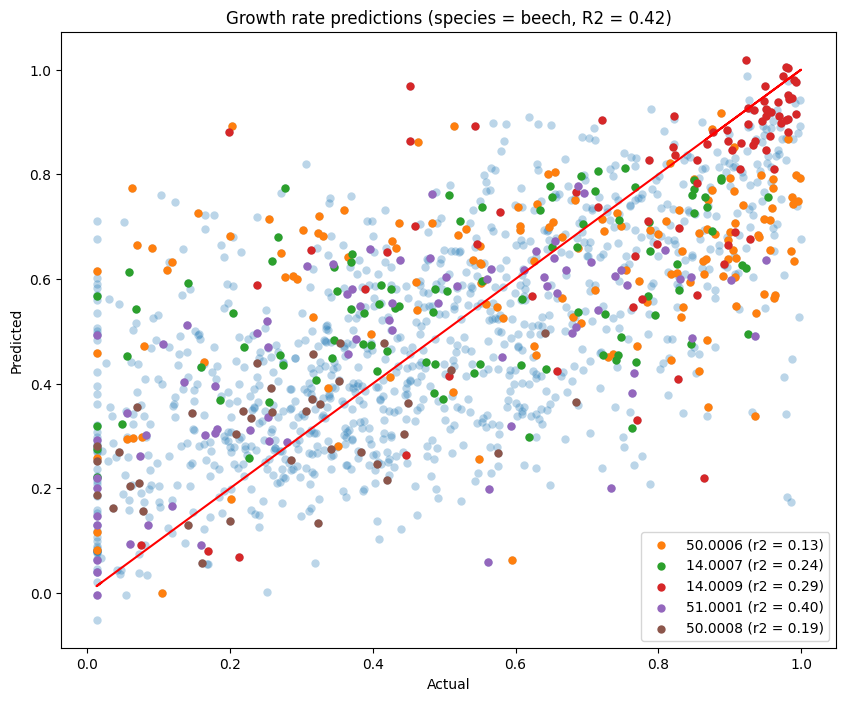

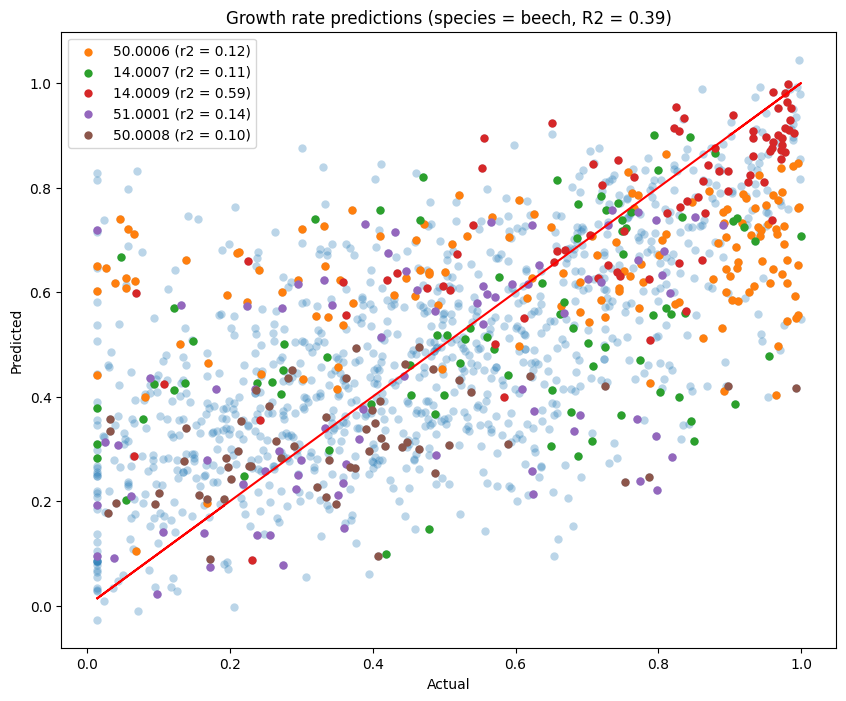

In [6]:
# Plot y_test vs y_pred
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from data import load_data

species = "beech"
results = all_results["beech"]

data = load_data(species)

plot_ids = (
    data.group_by("plot_id")
    .len()
    .sort("len", descending=True)
    .head(5)
    .select("plot_id")
    .to_series()
    .to_list()
)

for fold in range(5):
    # Get the results for the current fold
    _, y_true, y_pred = results.get_data(fold, "test")

    # Calculate R2
    r2_test = r2_score(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    plt.plot(y_true, y_true, color="red")
    plt.scatter(y_true, y_pred, alpha=0.3, linewidths=0)

    for plot_id in plot_ids:
        # Get the indices of the current fold
        indices = (
            data["plot_id"][results.get_indices(fold, "test")] == plot_id
        ).arg_true()
        r2_fold = r2_score(y_true[indices], y_pred[indices])

        plt.scatter(
            y_true[indices],
            y_pred[indices],
            label=f"{plot_id} (r2 = {r2_fold:.2f})",
            linewidths=0,
        )

    plt.legend()
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Growth rate predictions (species = {species}, R2 = {r2_test:.2f})")

# Feature importance by species

Here we show how feature importance varies by species.

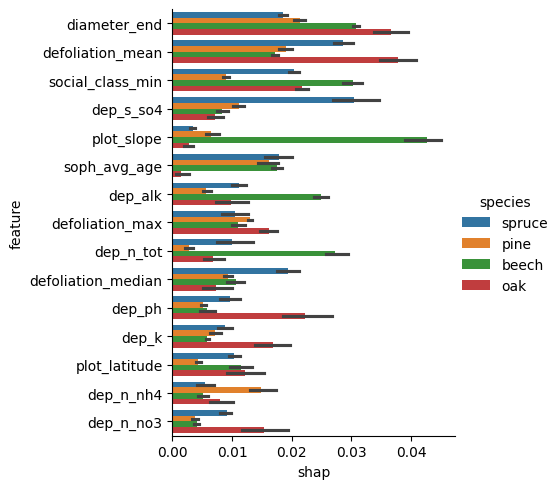

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

features = results.X.columns
top_n = 15

feature_importances = (
    pl.from_dicts(
        [
            {
                "species": species,
                "fold": fold,
                **dict(
                    zip(
                        features,
                        np.absolute(results.shap_values[fold].values).mean(axis=0),
                    )
                ),
            }
            for species, results in all_results.items()
            for fold in range(5)
        ]
    )
    .unpivot(
        on=pl.selectors.exclude("species", "fold"),  # type: ignore
        index=["species", "fold"],
        variable_name="feature",
        value_name="shap",
    )
    .with_columns(pl.col("shap").mean().over("feature").alias("importance"))
)

# Define order of features
order = (
    feature_importances.group_by("feature")
    .agg(pl.col("importance").mean().alias("importance"))
    .sort("importance", descending=True)["feature"]
    .to_list()[:top_n]
)

sns.catplot(
    feature_importances, x="shap", y="feature", hue="species", kind="bar", order=order
)

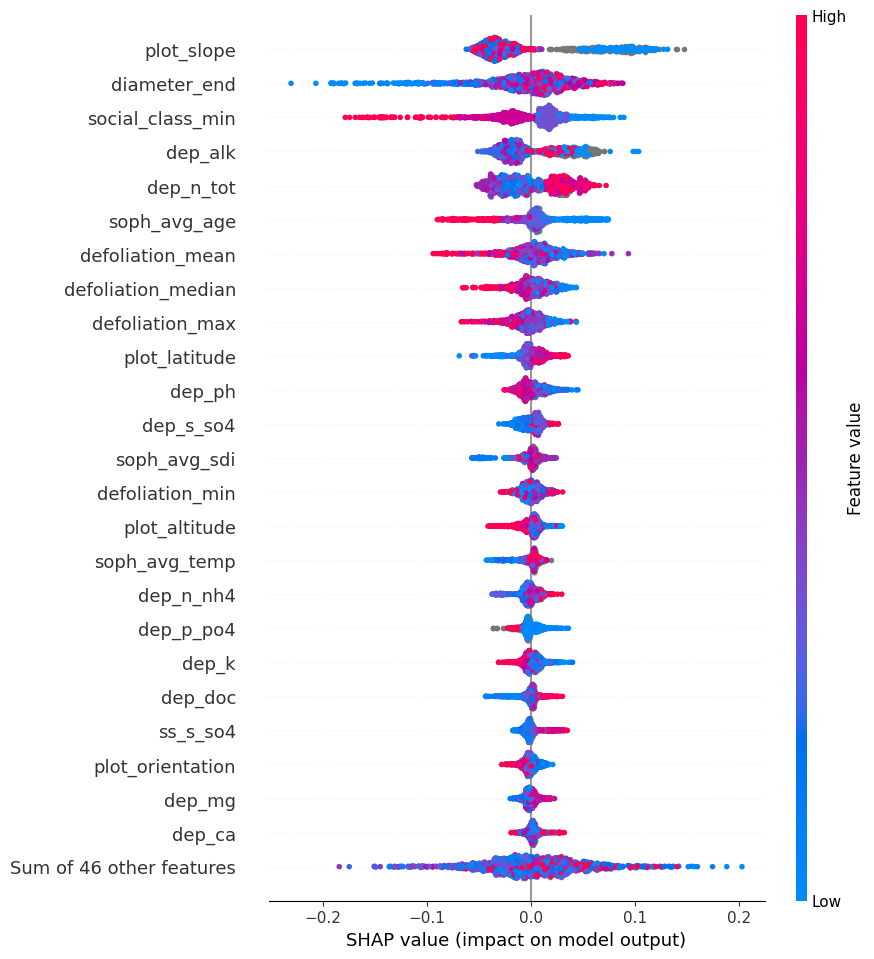

In [8]:
species = "beech"

results = all_results[species]

for fold in range(5):
    shap.plots.beeswarm(results.get_shap_values(fold, "test"), max_display=25)
    break  # TODO: remove for validation

## Custom plot of shapley values with interacting feature

We can compute the Shapley interactions using `get_shap_interactions`, which returns a tensor `(# samples, # features, # features)`, where each slice along the first axis is a symmetric matrix of interaction values, whose each row sums to the Shapley value for this feature. The diagonal entries represent the "main effect" attributed to that feature, whereas other entires represent the first-order interactions with every other feature.

> NOTE: Overall, it seems that these results aren't trustworthy and are too noisy.

We can possibly try to perform dimensionality reduction and/or visualization of matrices.

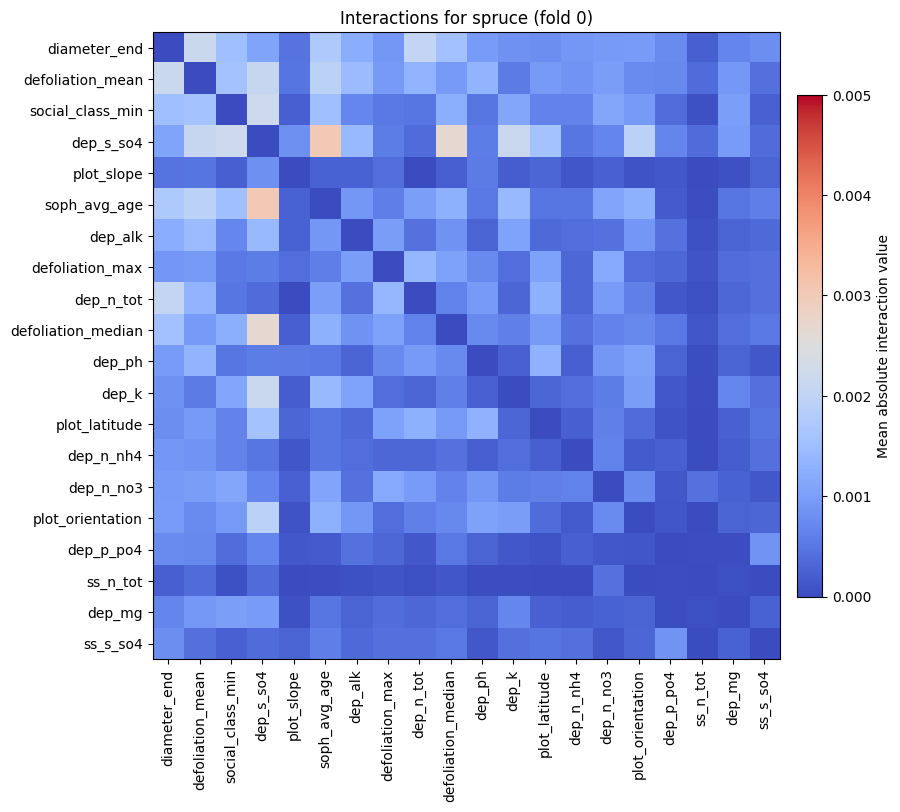

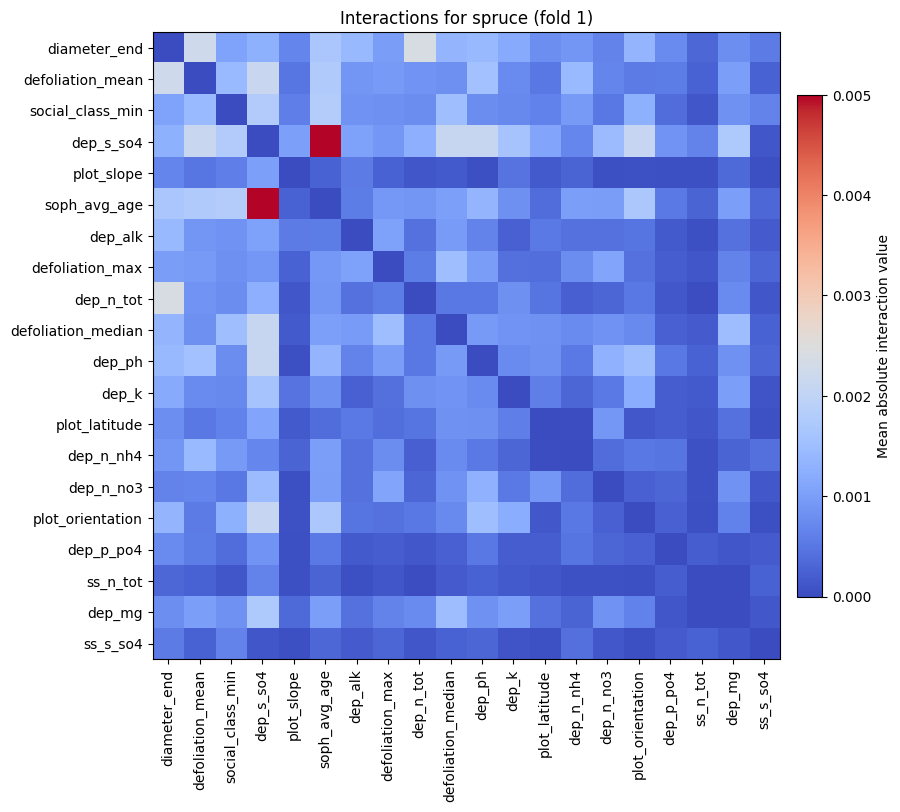

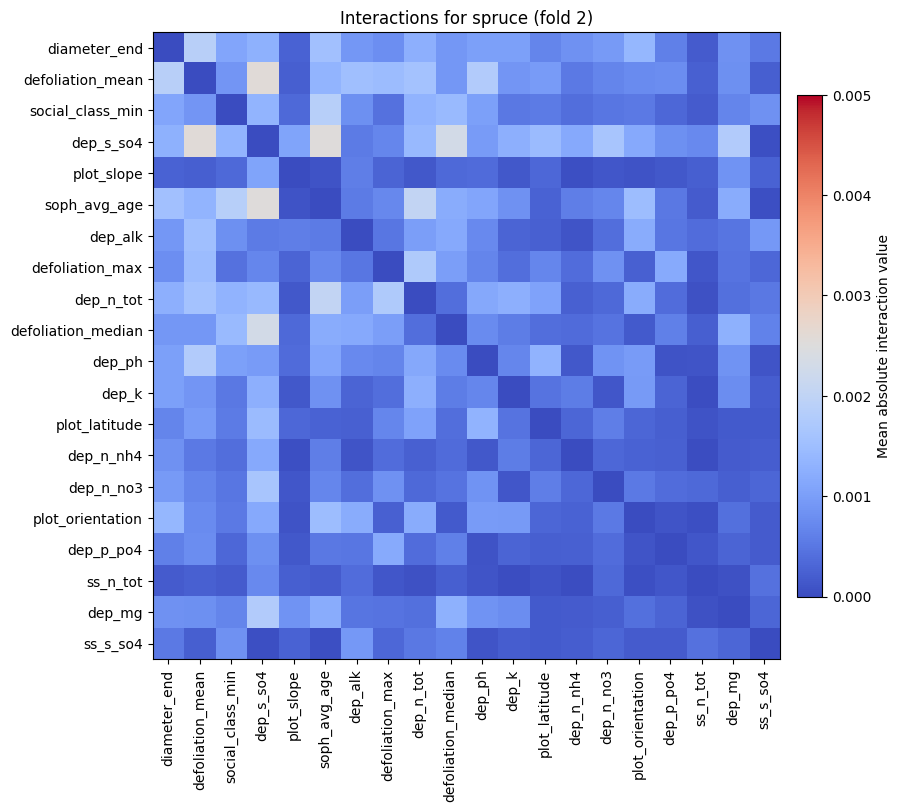

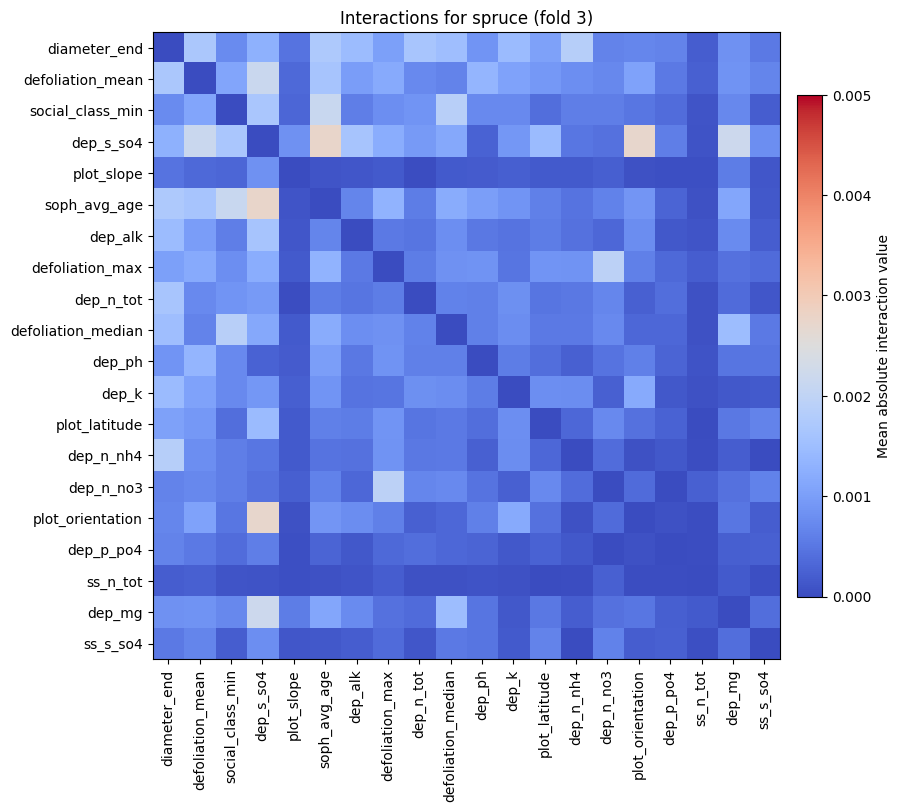

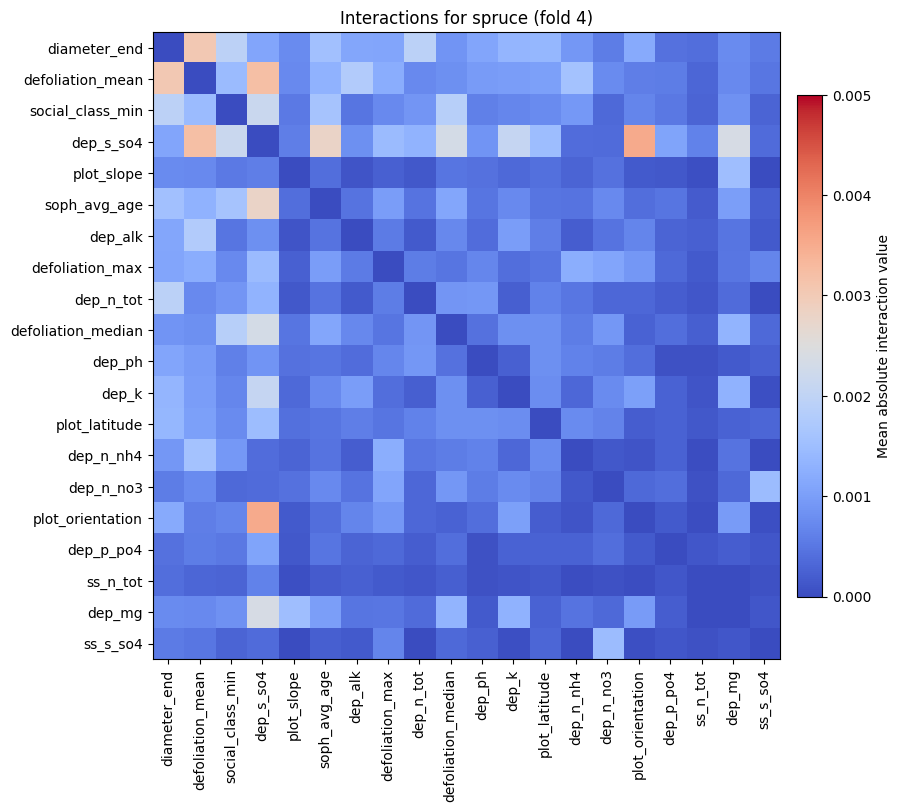

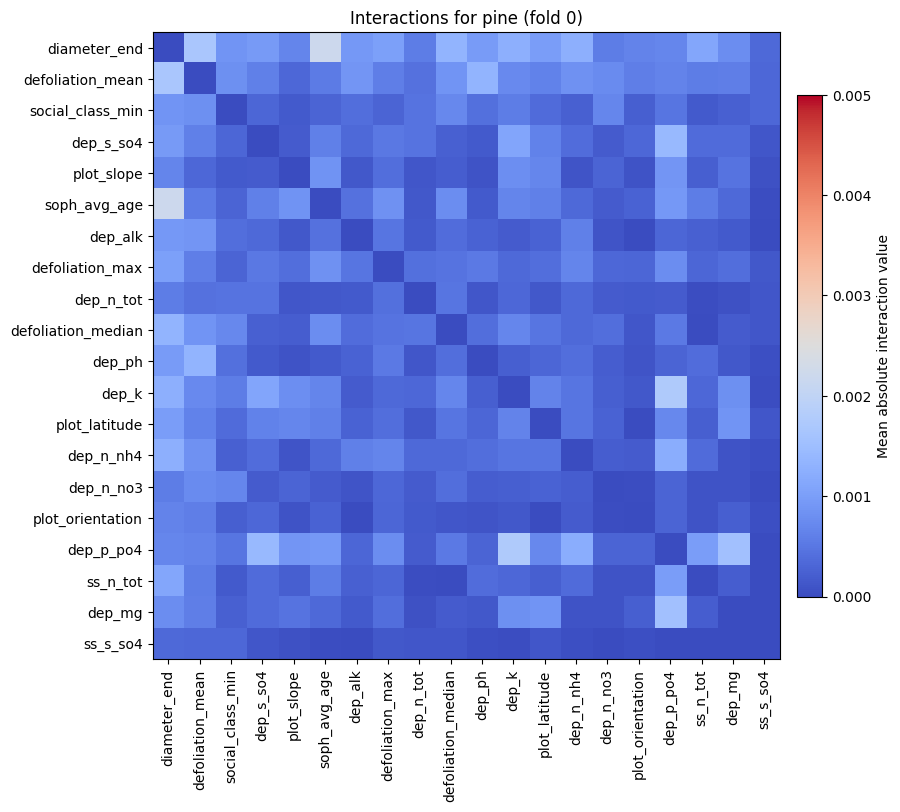

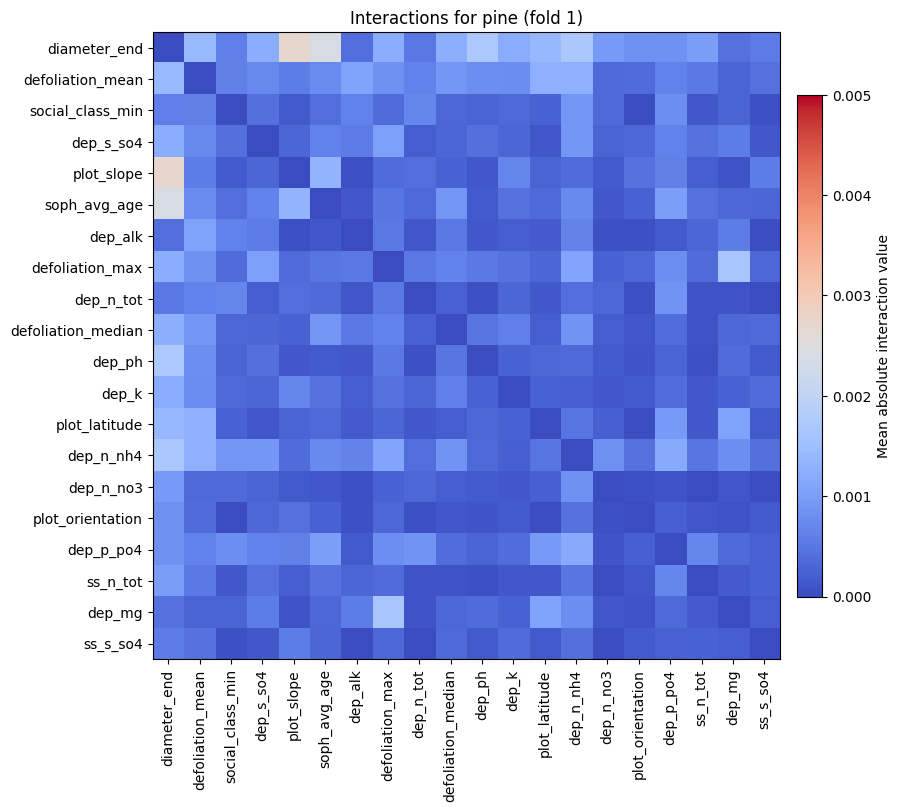

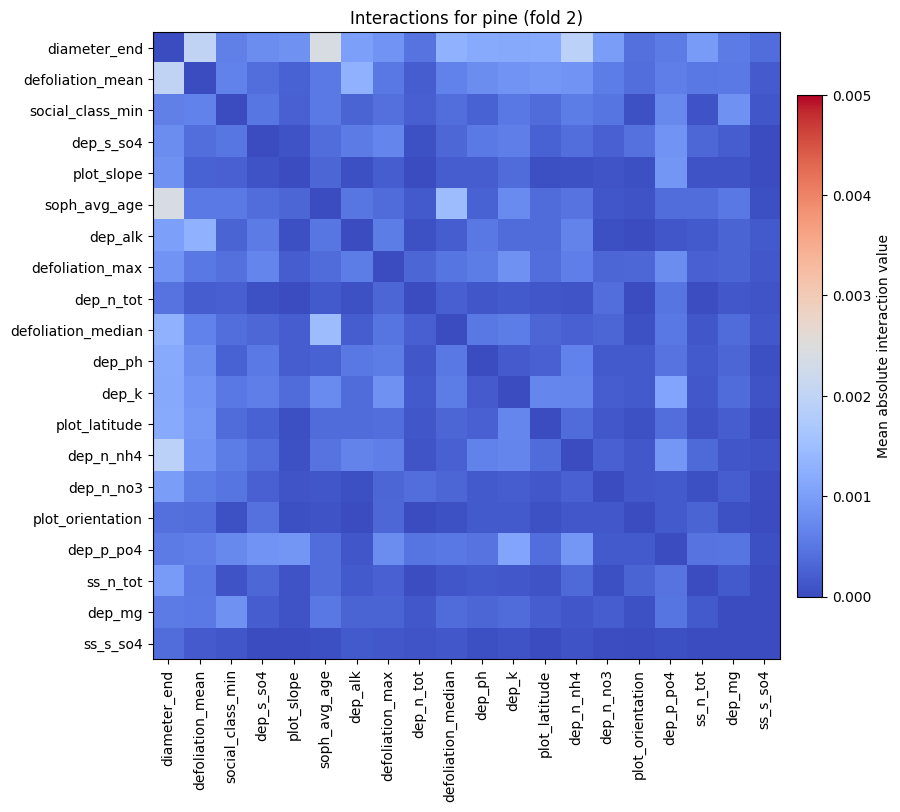

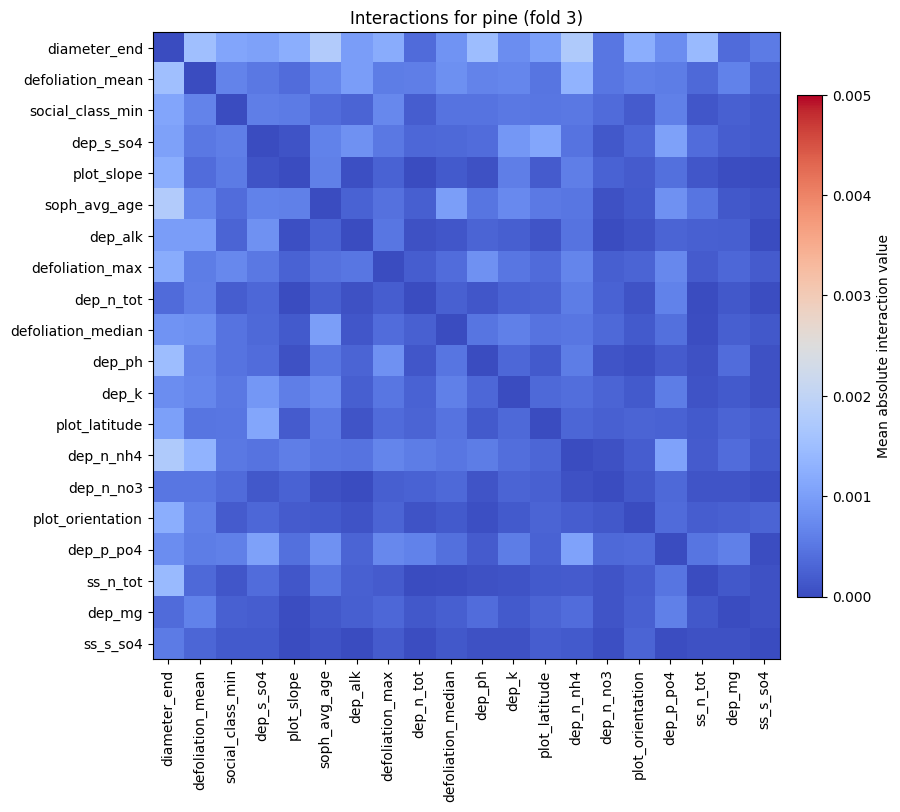

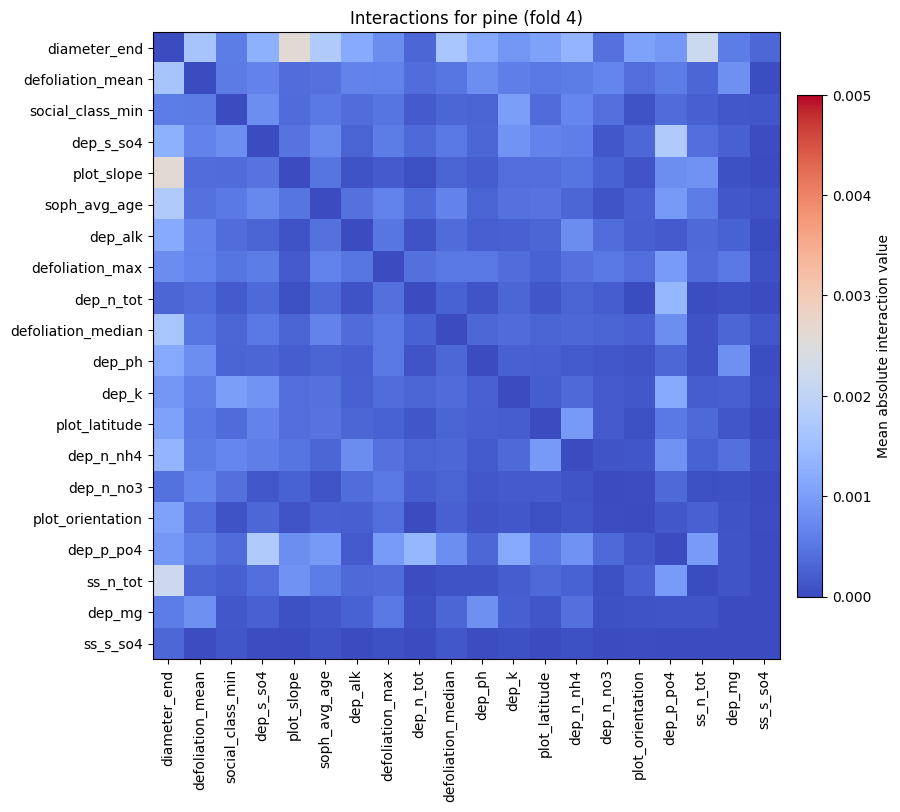

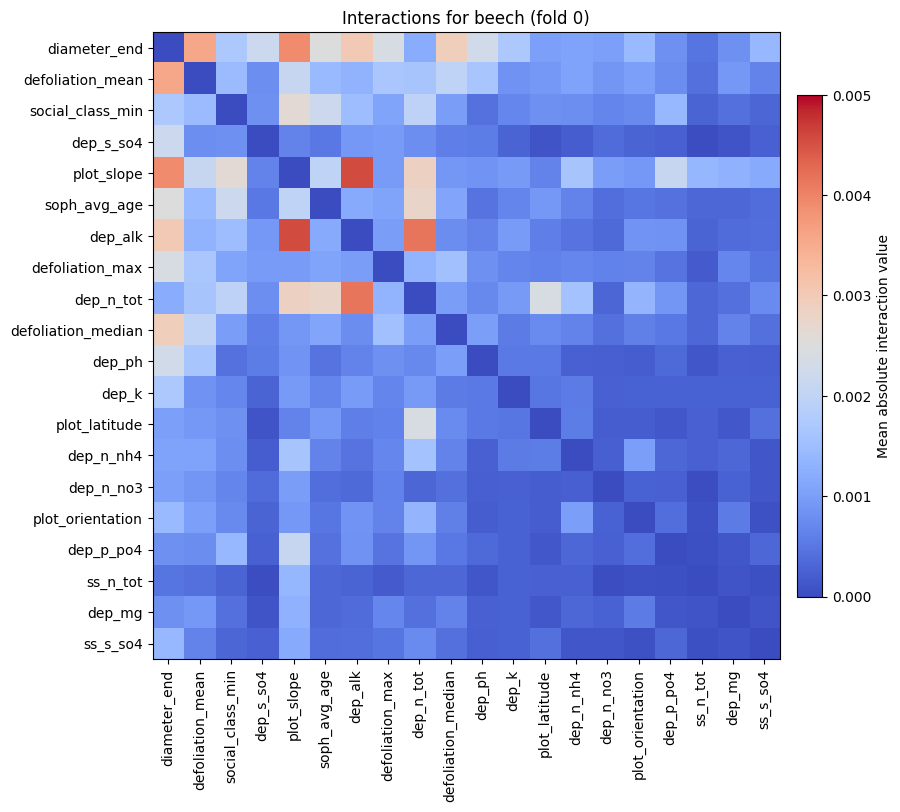

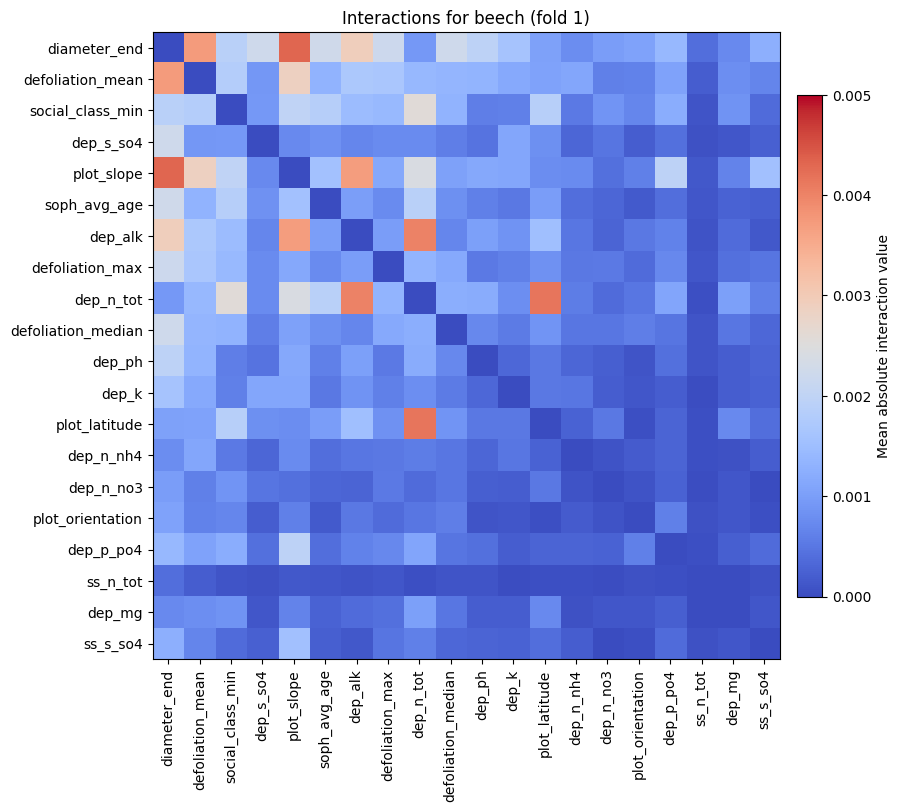

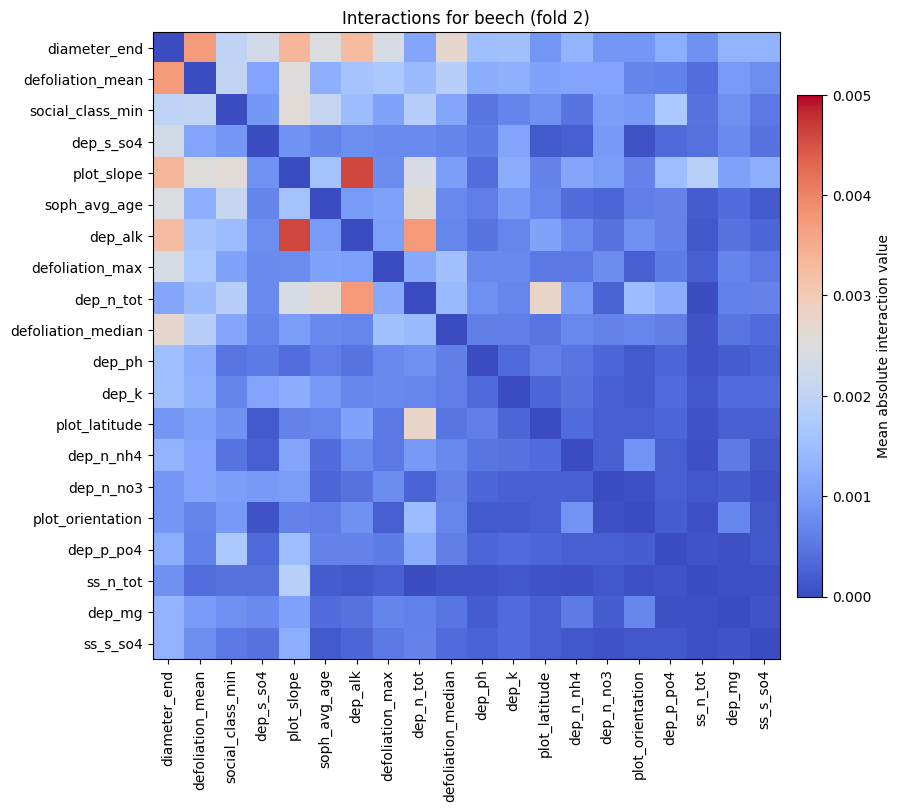

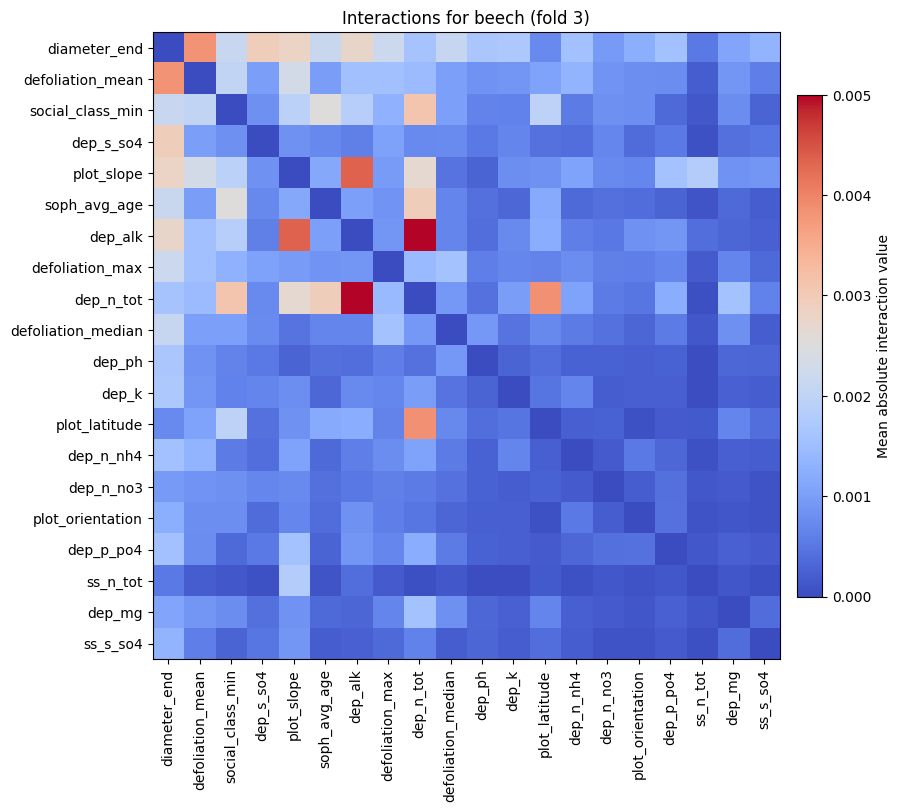

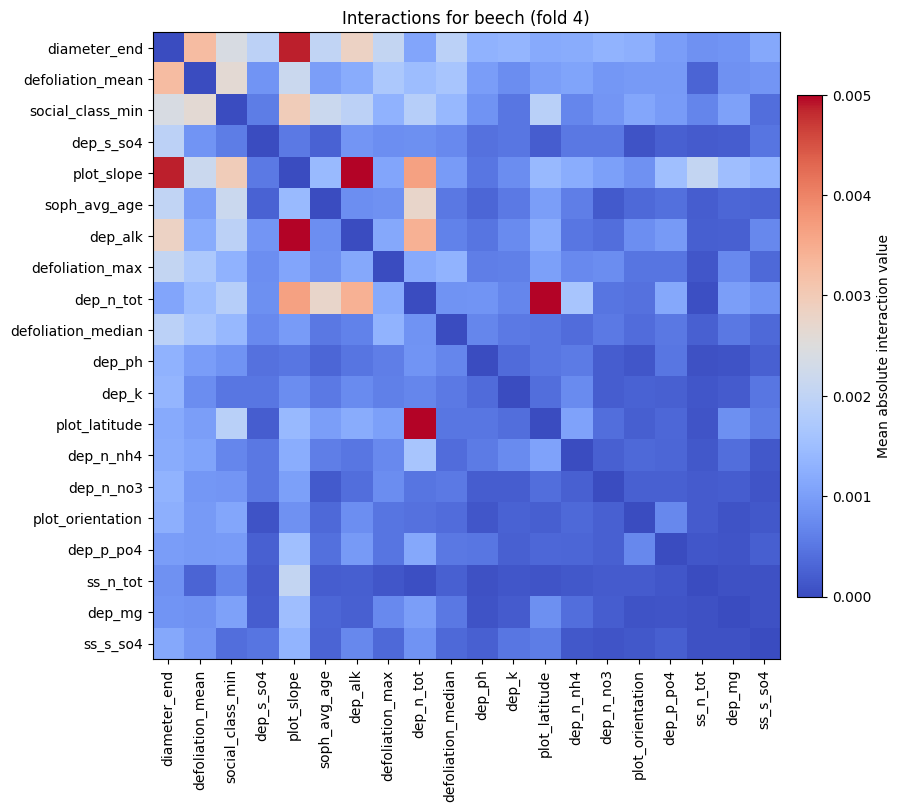

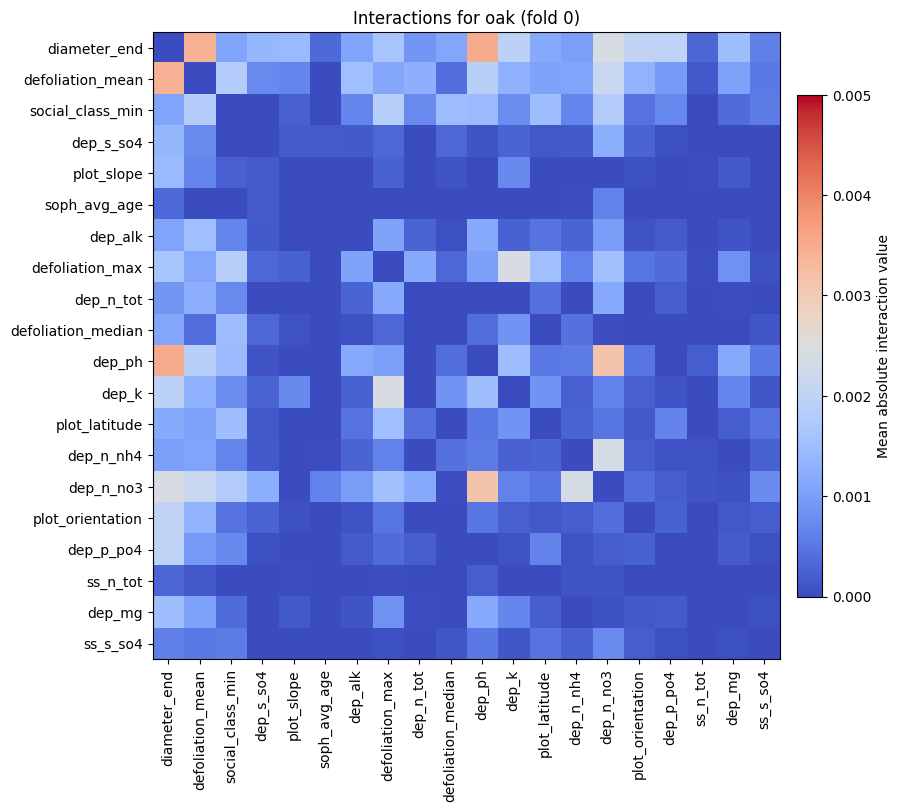

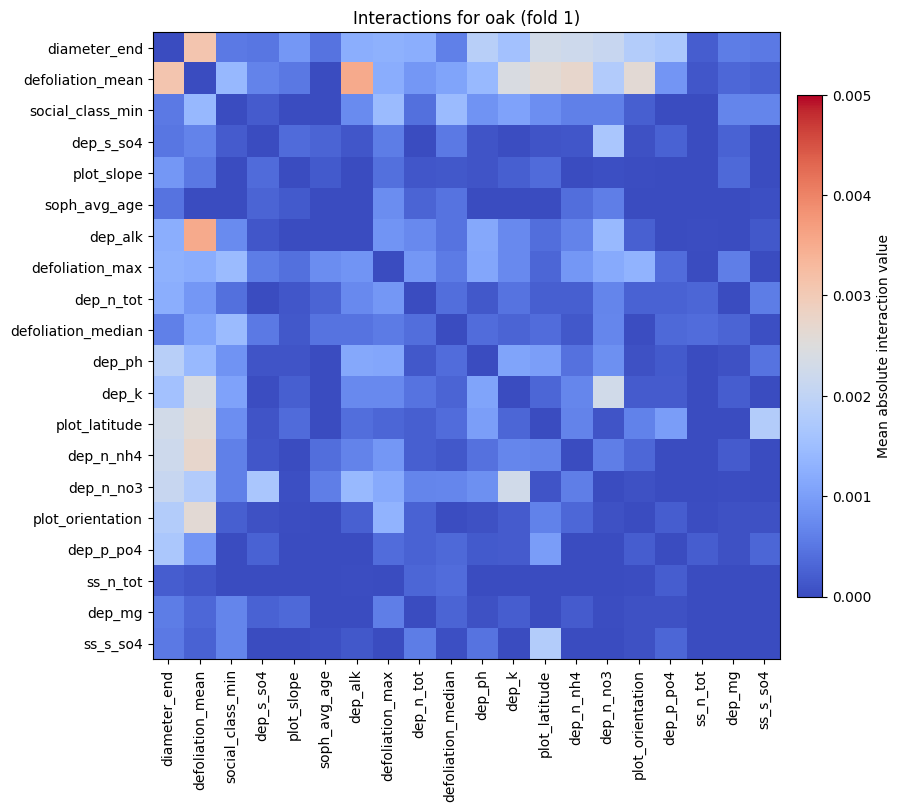

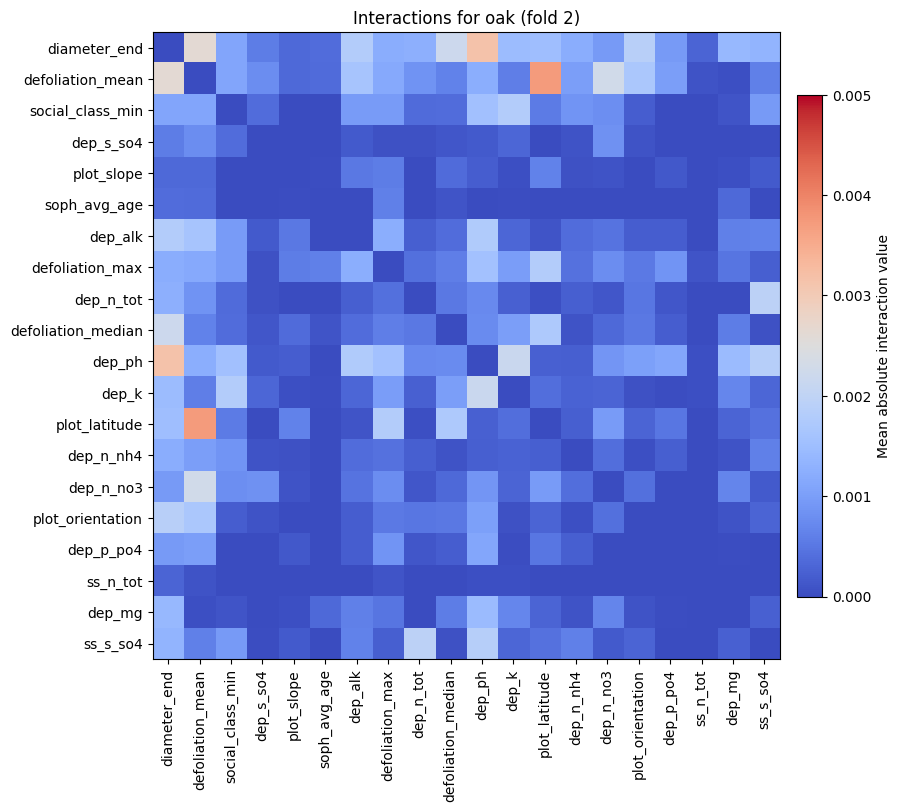

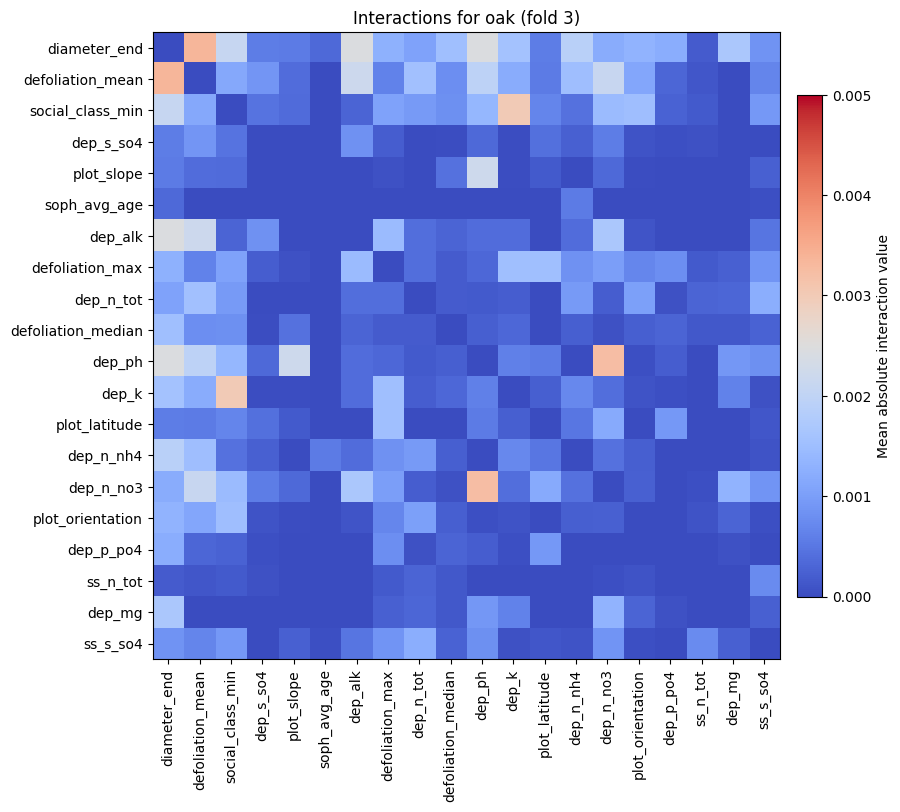

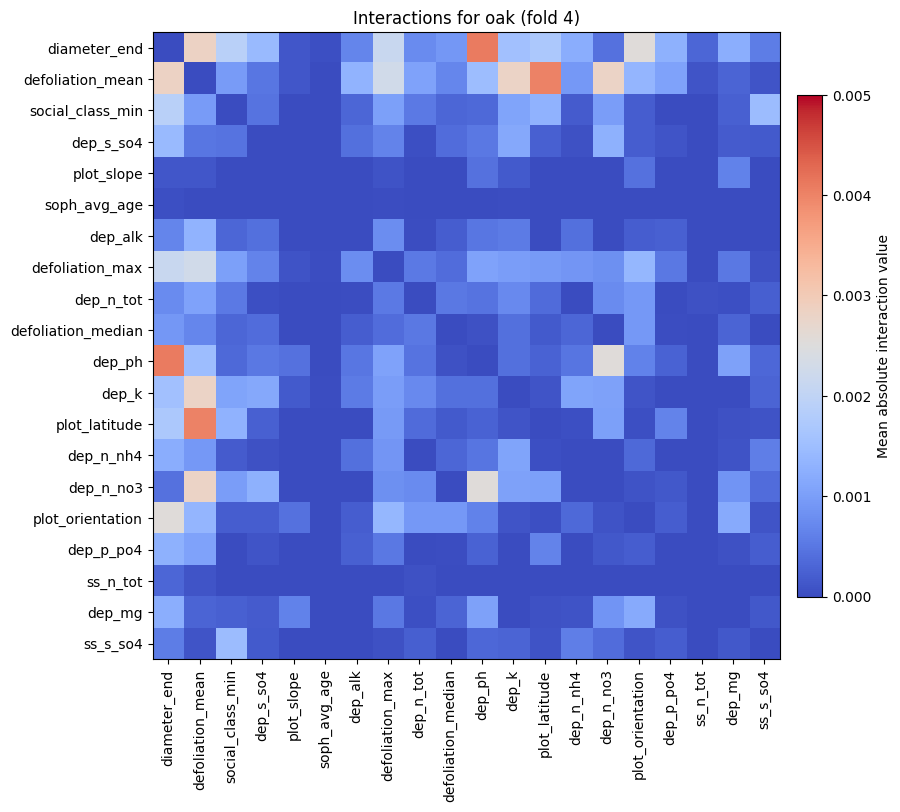

In [18]:
from explain import plot_interaction_matrix

top_n_features = top_features = (
    feature_importances.select("feature", "importance")
    .unique()
    .sort("importance", descending=True)
    .head(20)["feature"]
    .to_list()
)

# Loop over the species
for species in all_species:
    results = all_results[species]

    # Loop over the folds
    for fold in range(5):
        # Plot the mean absolute interaction values for the selected feature as a heatmap
        plt.figure(figsize=(10, 8))
        ax = plt.gca()

        interactions = plot_interaction_matrix(
            results, fold, top_n=top_n_features, ax=ax
        )
        plt.tight_layout()
        plt.title(f"Interactions for {species} (fold {fold})")

        plt.savefig(f"figures/{species}-interactions-{fold}.png")

shape: (10, 2)
┌─────────────────┬─────────────┐
│ feature         ┆ interaction │
│ ---             ┆ ---         │
│ str             ┆ f64         │
╞═════════════════╪═════════════╡
│ plot_latitude   ┆ 0.004009    │
│ diameter_end    ┆ 0.002824    │
│ dep_n_no3       ┆ 0.0028      │
│ dep_k           ┆ 0.002795    │
│ defoliation_max ┆ 0.002275    │
│ soph_avg_precip ┆ 0.001738    │
│ dep_na          ┆ 0.001722    │
│ dep_cl          ┆ 0.001704    │
│ ss_cl           ┆ 0.001535    │
│ dep_ph          ┆ 0.001493    │
└─────────────────┴─────────────┘


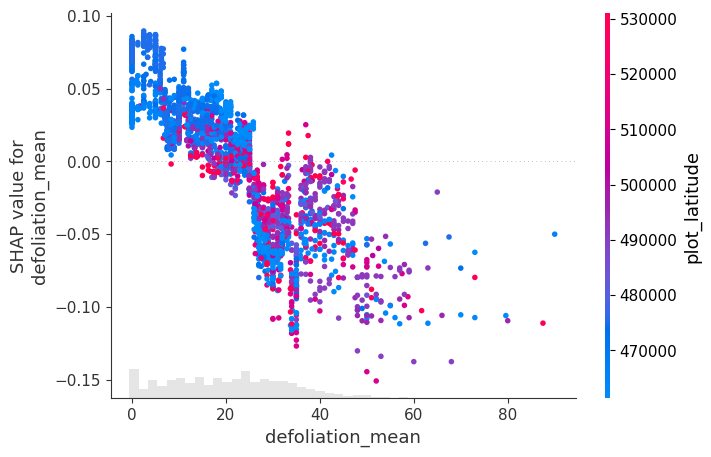

In [10]:
feature = "defoliation_mean"

# Construct a DataFrame of the interaction values
feature_idx = results.X.columns.index(feature)

df_interactions = pl.from_numpy(
    interactions[:, feature_idx, :],
    schema=results.X.columns,
)

# Show the top-10 interactions for the selected feature
top_interactions = (
    df_interactions.unpivot(
        pl.selectors.exclude(feature),
        variable_name="feature",
        value_name="interaction",
    )
    .group_by("feature")
    .agg(pl.col("interaction").abs().mean())
    .sort("interaction", descending=True)
    .head(10)
)

print(top_interactions)

shap.plots.scatter(
    results.shap_values[fold][:, feature],
    color=results.shap_values[fold][:, top_interactions["feature"].item(0)],
)

[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=2.3995604706268593e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3995604706268593e-05
[LightGBM] [Warning] lambda_l2 is set=0.11844729240519608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11844729240519608
[LightGBM] [Warning] bagging_fraction is set=0.77263507152719, subsample=1.0 will be ignored. Current value: bagging_fraction=0.77263507152719
[LightGBM] [Warning] min_data_in_leaf is set=29, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=29
[LightGBM] [Warning] feature_fraction is set=0.9317258064140852, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9317258064140852
[LightGBM] [Warning] Unknown parameter: min_gain_split
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current 

/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/research/hybrid-ai-lab/icp-paper/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/gmermoud/code/res

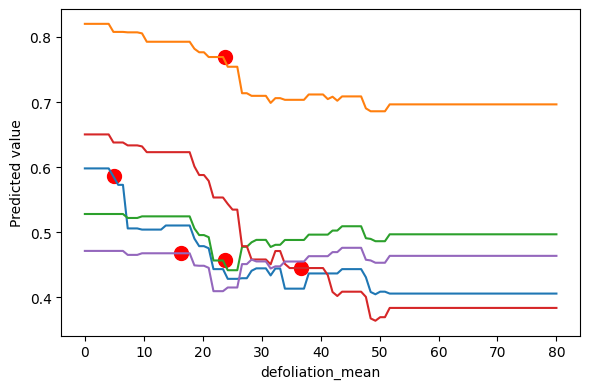

In [11]:
from explain import plot_ceteris_paribus_profile

fold = 0

X, _, _ = results.get_data(fold, "test")

plt.figure(figsize=(6, 4))
ax = plt.gca()

# Select 5 random instances
instance_ids = np.random.choice(np.arange(X.shape[0]), 5)

for instance_id in instance_ids:
    feature_range, y_pred = plot_ceteris_paribus_profile(
        results.estimators[fold], X, instance_id, feature, ax=ax
    )

plt.tight_layout()

## Explain a subset of the data

We explain only data within:

- A given `plot_id` (to verify that the model is capable of capturing tree-specific features).
- A given climatic area (`boreal`, `high_altitude`, `dry`).

In [12]:
from typing import cast

fold_id = 0
plot_id = plot_ids[1]
split = "all"
num_samples = 100

# Different subsets of the data
subparts = {}
# Extract indices of plot_id
# indices = df.select(
#     pl.arg_where(pl.col("plot_id") == plot_id).alias("idx")
# ).to_series()

# # Extract only boreal vs temperate plots
subparts["boreal"] = data.select(
    pl.arg_where(pl.col("plot_latitude") >= 520000)
).to_series()
# subparts["temperate"] = df.select(
#     pl.arg_where(pl.col("plot_latitude") < 500000)
# ).to_series()

# Extract plots with high vs low altitude
subparts["high_altitude"] = data.select(
    pl.arg_where(pl.col("plot_altitude") >= 1200)
).to_series()
# subparts["low_altitude"] = df.select(
#     pl.arg_where(pl.col("plot_altitude") <= 250)
# ).to_series()

# Extract only growth periods with high vs low precipitation
subparts["dry"] = data.select(pl.arg_where(pl.col("soph_avg_precip") < 400)).to_series()
# subparts["humdid"] = df.select(
#     pl.arg_where(pl.col("soph_avg_precip") > 800)
# ).to_series()

for label, indices in subparts.items():
    print(f"Decision plots for {label} ({len(indices)} samples)")

    X, y_true, y_pred = (
        results.X[indices],
        results.y_true[indices],
        results.y_pred[fold_id][indices],
    )
    print("# of features:", X.shape[1])
    print("# of samples:", X.shape[0])
    expected_value = cast(float, results.explainers[fold_id].expected_value)
    print(f"Expected target: {expected_value * 100:.2f}%")

    # Select n random samples
    select_indices = np.random.choice(X.shape[0], num_samples, replace=False)

    features = X[select_indices, :].to_pandas()
    shap_values = results.get_shap_values(fold_id, split)[select_indices]

    shap.decision_plot(
        expected_value, shap_values.values, features, feature_order="importance"
    )

Decision plots for boreal (221 samples)


OutOfBoundsError: gather indices are out of bounds

In [ ]:
# Plot the dependence plot for the top 10 features
top_features = (
    feature_importances.select("feature", "importance")
    .unique()
    .sort("importance", descending=True)
    .head(10)["feature"]
    .to_list()
)

for feature in top_features:
    shap.dependence_plot(
        feature,
        results.get_shap_values(fold_id, "all").values[indices],
        X.to_pandas(),
        interaction_index="auto",
        show=True,
        alpha=0.4,
    )

In [ ]:
# Visualize Shapley values using a PCA
from sklearn.decomposition import PCA

# Perform PCA for fold 0
fold = 0
pca = PCA(n_components=2)

# Normalize the Shapley values
X_shap = results.shap_values[fold].values
X_shap = np.nan_to_num((X_shap - X_shap.mean(axis=0)) / X_shap.std(axis=0))

# Train the PCA model
X_pca = pca.fit_transform(X_shap)

In [ ]:
# Scatter plot of the PCA with the top-5 features projected
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.1)

for label, indices in subparts.items():
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=label, alpha=0.6)

plt.legend()

# Compute the top features
feature_importances = np.absolute(results.shap_values[fold].values).mean(axis=0)
top_features = np.argsort(feature_importances)[::-1][:10]
print("Top features:", features.columns[top_features].to_list())

# Project the top-5 features
X_features = (
    400 * pca.transform(np.eye(X_shap.shape[1])) * feature_importances[:, np.newaxis]
)
for idx in top_features:
    plt.arrow(0, 0, X_features[idx, 0], X_features[idx, 1], color="black", width=0.05)
    plt.text(
        X_features[idx, 0] + 0.1,
        X_features[idx, 1] + 0.1,
        features.columns[idx],
        fontsize=12,
    )